# QA System

## Question Similarity Model

In [ ]:
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')

### S-Bert Train

In [ ]:
#train model
%%run -i /Users/yqinamz/Desktop/QA_BOT/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/train_QSM_Sbert.py \
--pretrain_model_path '/home/yqinamz/output/quora_sts-bert-base-nli-mean-tokens-2020-08-17_20-53-14/' \
--model_name '/home/yqinamz/output/Sbert_test' \
--train_data_path '/home/yqinamz/QA_Bot/QA_EXP/EXP_1002/Mix_2USE_8R_1009/' 




### Inference on Question-Pairs

In [ ]:
%%run -i /Users/yqinamz/Desktop/QA_BOT/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/QSM_inference.py \
--saved_model_path '/home/yqinamz/output/quora_sts-bert-base-nli-mean-tokens-2020-08-17_20-53-14/' \
--test_data_path '/home/yqinamz/QA_Bot/QA_EXP/EXP_1002/Mix_2USE_8R_1009/test_sample.tsv'


### Real-Time Prediction for QSM

## Information Retrieval

### Training IR Model

In [ ]:
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')

In [ ]:
## Here model_name_or_path could be any mapping that AutoModel supports if architecture is ['bi', 'cross'] 
## and model_name_or_path ould be any mapping that AutoModelForClassification if architecture is 'cross-default'
## if you want to add new model you need add new instance of in ir_model to get the right output
## NOTE: model_name_or_path COULD BE A LOCAL PATH OR CHECKPOINT DIRECTORY WHERE THE MODEL WILL START FINETINING FROM THAT POINT
## NOTE: model_type can be anythinf for now. It is not being used.

%%time
%run -i /home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/information_retrieval/ir_train.py \
        --train_data_path '/data/QAData/InformationRetrievalData/amazon/train.tsv' \
        --test_data_path '/data/QAData/InformationRetrievalData/amazon/test.tsv' \
        --model_name_or_path 'bert-base-uncased' \
        --architecture 'cross' \
        --do_lower_case \
        --train_batch_size 64 \
        --test_batch_size 128 \
        --num_train_epochs 2 \
        --gpu 2,3,4,5 \
        --save_steps 1000 \
        --print_freq 500 \
        --output_dir '/home/srikamma/efs/work/QASystem/QAModel/output_torch/cross/ir_artifacts/bertbase/'
    

### FineTuning IR Model

In [ ]:
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')

In [ ]:
%%time
%run -i /home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/information_retrieval/ir_train.py \
        --train_data_path '/data/QAData/InformationRetrievalData/amazon/finetune_rank_train.tsv' \
        --test_data_path '/data/QAData/InformationRetrievalData/amazon/finetune_rank_test.tsv' \
        --model_name_or_path '/home/srikamma/efs/work/QASystem/QAModel/output_torch/cross/ir_artifacts/bertbase/' \
        --architecture 'cross' \
        --do_lower_case \
        --train_batch_size 64 \
        --test_batch_size 128 \
        --num_train_epochs 2 \
        --gpu 2,3,4,5 \
        --save_steps 1000 \
        --print_freq 500 \
        --output_dir '/home/srikamma/efs/work/QASystem/QAModel/output_torch/cross/ir_artifacts/bertbase_finetuned/'

### Bulk Inference IR Model

In [ ]:
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')

In [ ]:
%%time
%run -i /home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/information_retrieval/ir_inference_mlmodel.py \
    --test_data_path '/data/QAData/InformationRetrievalData/amazon/finetune_rank_test.tsv' \
    --test_batch_size 128 \
    --model_name_or_path '/home/srikamma/efs/work/QASystem/QAModel/output_torch/cross/ir_artifacts/bertbase_finetuned/' \
    --architecture 'cross' \
    --do_lower_case \
    --prediction_file 'prediction.csv' \
    --gpu 2,3 \
    --output_dir '/home/srikamma/efs/work/QASystem/QAModel/output_torch/cross/ir_artifacts/bertbase_inference_finetuned/'

#### Plotting

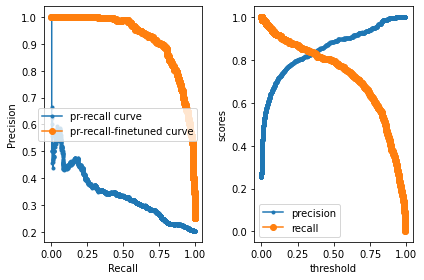

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
bertbase_prediction_file = '/home/srikamma/efs/work/QASystem/QAModel/output_torch/cross/ir_artifacts/bertbase_inference/prediction.csv'
bertbase_finetuned_prediction_file = '/home/srikamma/efs/work/QASystem/QAModel/output_torch/cross/ir_artifacts/bertbase_inference_finetuned/prediction.csv'
pred = pd.read_csv(bertbase_prediction_file,sep='\t')
pred_finetuned = pd.read_csv(bertbase_finetuned_prediction_file,sep='\t')
precision, recall, threshold = precision_recall_curve(pred.actuals.to_list(),pred.predictions.to_list())
precision_finetuned, recall_finetuned, threshold_finetuned = precision_recall_curve(pred_finetuned.actuals.to_list(),pred_finetuned.predictions.to_list())


pyplot.subplot(1,2,1)
pyplot.plot(recall,precision,marker='.',label='pr-recall curve')
pyplot.plot(recall_finetuned,precision_finetuned,marker='o',label='pr-recall-finetuned curve')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
#show legend
pyplot.legend()

pyplot.subplot(1,2,2)
pyplot.plot(threshold_finetuned,precision_finetuned[:-1],marker='.',label='precision')
pyplot.plot(threshold_finetuned,recall_finetuned[:-1],marker='o',label='recall')
pyplot.xlabel('threshold')
pyplot.ylabel('scores')
# show the legend
pyplot.legend()
# show the plot
pyplot.tight_layout()
pyplot.show()

In [5]:
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')
from information_retrieval.ir_metrics import compute_acc_pr_rec_fs_metric
pr = 0.85
print('For precision of {}, recall = {}'.format(pr,recall_finetuned[np.argmin(precision_finetuned <= 0.85)]))
print('For precision of {}, threshold values = {}'.format(pr,threshold_finetuned[np.argmin(precision_finetuned <= pr)]))

trhold = 0.40
print('\n\nFor a treshold of {}'.format(trhold))
compute_acc_pr_rec_fs_metric(pred_finetuned.predictions.to_list(),pred_finetuned.actuals.to_list(),trhold)

For precision of 0.85, recall = 0.8144654088050315
For precision of 0.85, threshold values = 0.4004531502723694


For a treshold of 0.4


{'accuracy': 0.9337957124842371,
 'precision': 0.8491803278688524,
 'recall': 0.8144654088050315,
 'f-score': 0.8314606741573034}

### Real Time Inference IR Model

In [1]:
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')
from information_retrieval.ir_inference_mlmodel import ScorePrediction
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
%%time
query = 'how to cancel my prime membership'
passage = 'About Prime Gift Membership Cancellations: If you need to cancel a Prime gift membership that hasn\'t already been sent or has been sent but not redeemed, please contact us. Once a Prime gift membership has been redeemed by the recipient, it can\'t be canceled. The scheduled delivery date also can\'t be changed once your purchase has completed. If you need to update a delivery date, contact us so we can cancel the existing gift. You can then place a new order.'
out = ScorePrediction.get_document_score(query,passage)
print(out)

0.02034132555127144
CPU times: user 13 s, sys: 20 s, total: 33 s
Wall time: 6.86 s


### Bulk Inference (BM25 + IR) Model 

In [3]:
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')

In [ ]:
%%time
%run -i /home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/information_retrieval/ir_inference_combined.py \
    --passage_collection_path '/data/QAData/InformationRetrievalData/amazon/collection.json' \
    --qrels_path '/data/QAData/InformationRetrievalData/amazon/qrels.json' \
    --ir_model_name 'BM25Okapi' \
    --word_tokenizer_name 'simple_word_tokenizer' \
    --index_top_n 50 \
    --model_name_or_path 'output_torch/cross/ir_artifacts/bertbase_finetuned/' \
    --architecture 'cross' \
    --do_lower_case \
    --test_batch_size 512 \
    --gpu 2,3 \
    --prediction_file 'predictions.csv' \
    --output_dir '/home/srikamma/efs/work/QASystem/QAModel/output_torch/cross/ir_artifacts/bertbase_inference/'

In [6]:
# import sys
# import pandas as pd
# sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')
# from information_retrieval.ir_utils import load_passage_collection
# a = '/data/QAData/InformationRetrievalData/amazon/production_collection.json'
# passage_collection, pid_passage_tuple, passage_collection_ae = load_passage_collection(a)
# data = pd.read_csv('/data/QAData/InformationRetrievalData/amazon/finetune_rank_test.tsv',sep='\t')
# data

,qid,query,pid,passage,label
0,5059,A charge dispute,184,unknown charges there are several reasons why you might not recognize a charge if you want to review your complete order history go to your orders the following are common scenarios for unknown charges an amazon prime yearly subscription was renewed for more information go to manage your prime membership a bank has placed an authorization hold for recently canceled or changed orders when you place an order amazon contacts the issuing bank to confirm the validity of the payment method your bank reserves the funds until the transaction processes or the authorization expires but this is not an actual charge if you cancelled your order the authorization will be removed from your account according to the policies of your bank to remove an authorization contact your bank to clarify how long they hold authorizations for online orders an order was placed by a family member friend or coworker with access to your card number additional cards are associated with the credit or debit account a backordered or preordered item shipped a gift order shipped an order placed outside amazon using amazon pay amazon pay orders begin with p and are followed by digits check your amazon pay account for your order history for further assistance with any amazon pay transactions see the amazon pay help pages an order was split into multiple shipments or sent to multiple shipping addresses note this appears on your statement as separate charges if the charge is not explained by any of these situations contact us by phone and have the following information available date of the charge amount of the charge your name email address and phone number charge id a unique digit alphanumeric code that customer service can use to locate your charge e amazon a b cd prime now b b cd amzn mktp us b cd note this id only appears when the card is charged it is not present on pending charges authorizations use your order history to review your orders and shipments to compare the charges with the charges on your bank statement,1
1,5059,A charge dispute,200,why can not i log into my account if you are having trouble logging in you may be entering incorrect account information or you may need to reset your password here are some things to check email address your email address must be in the format or net org etc if you have more than one email address make sure you are using the correct email address and password combination mobile phone number if you created your account with a mobile phone number you will need to use your mobile phone number to log into your account make sure that you are including your country code in your mobile phone number password check caps lock and num lock on your keyboard passwords are case sensitive so password and password are recognized as two different passwords if you are sure you are using the correct email address or mobile phone number try to reset your password,0
2,5059,A charge dispute,112,multiple charges for the same order orders may be split into multiple shipments or even multiple orders because we charge for items when they are shipped this may result in multiple charges however the total amount charged should add up to the amount displayed when you placed the order items from a single order may be sent as more than one shipment for several reasons the most common are one or more of the items was sold and dispatched by a marketplace seller we dispatched the items from different fulfillment centers the items had different availabilities and you selected the i want my items faster ship items as they become available option at checkout the items are being delivered to more than one address selecting different delivery addresses for the items in an order will result in each delivery address being assigned a different order number the order summary in your account will show the amount charged for each delivery as well as the total charged per order,0
3,5059,A charge dispute,29,about

In [8]:
df = pd.DataFrame(passage_collection_ae.items(),columns=['pid','passage'])
#passage_collection_ae[pd.merge(data,df,on=['passage'],how='left')['pid'][0]]
pd.merge(data,df,on=['passage'],how='left')['pid']

KeyError: 'pid'

### Real Time Inference (BM25 + IR) Model

In [ ]:
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')
from information_retrieval.ir_inference_combined import ScorePrediction
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [ ]:
%%time
query = 'yes'
out = ScorePrediction.get_documents(query)

In [ ]:
out


In [ ]:
x = [ScorePrediction.transform(query,i[3]) for i in out]
type(x[0])

In [ ]:
%%time
import torch
with torch.no_grad():
    ScorePrediction.ml_model(*out)

## Answer Extraction

### Train Answer Extraction Model

In [ ]:
%%time
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')

%run -i /home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/answer_extraction/run_squad_final.py \
    --model_type bert \
    --model_name_or_path bert-base-uncased \
    --do_lower_case \
    --do_train \
    --do_eval \
    --data_dir '/data/QAData/AnswerExtractionData/amazon' \
    --train_file 'train_answerextraction_100.tsv' \
    --predict_file 'test_answerextraction_100.tsv' \
    --squad_data_dir '/data/QAData/AnswerExtractionData/squad' \
    --squad_train_file 'train-v2.0.json' \
    --squad_predict_file 'dev-v2.0.json' \
    --per_gpu_train_batch_size 12 \
    --learning_rate 3e-5 \
    --num_train_epochs 2.0 \
    --max_seq_length 384 \
    --doc_stride 128 \
    --version_2_with_negative \
    --add_neg \
    --output_dir '/home/srikamma/efs/work/QASystem/QAModel/output_answer_extraction/bert_output_final'

### Fine Tuning Answer Extraction with New Amazon Data

In [ ]:
import pandas as pd
realtime_new_annotations = [
    {
    "qid":20000,
    "query":"cancel my music subscription",
    "answer":"If you subscribed to Amazon Music Unlimited through iTunes visit the [Apple website](https://support.apple.com/HT202039) to cancel your subscription. If you subscribed through a third-party, such as a mobile service provider, contact them for further assistance. Go to [Your Amazon Music Settings](https://www.amazon.com/music/settings). Go to the Amazon Music Unlimited section. Select the Cancel option in your Subscription Renewal details. Confirm the cancellation",
    "passage":"Cancel Amazon Music Unlimited Subscription: Cancel your subscription online. If you subscribed to Amazon Music Unlimited through iTunes visit the [Apple website](https://support.apple.com/HT202039) to cancel your subscription. If you subscribed through a third-party, such as a mobile service provider, contact them for further assistance. Go to [Your Amazon Music Settings](https://www.amazon.com/music/settings). Go to the Amazon Music Unlimited section. Select the Cancel option in your Subscription Renewal details. Confirm the cancellation. Note: You can continue to access Amazon Music Unlimited until the end date. After this date, any Amazon Music Unlimited titles you've added to Library will be grayed out, with playback options removed.Cancelling an Amazon Music Unlimited subscription also ends membership to Amazon Music HD. Video: Cancel Amazon Music Unlimited. For more help, try our [Amazon Music forum](https://www.amazon.com/gp/redirect.html/ref=hp_cr_music_forum?location=https://www.amazonforum.com/s/amazon-music&token=728A8569DD99E77B59F36EE4739090DC4E1BA6F8&source=standards). [](https://www.amazon.com/gp/redirect.html/ref=hp_cr_music_forum?location=https://www.amazonforum.com/s/amazon-music&token=728A8569DD99E77B59F36EE4739090DC4E1BA6F8&source=standards)"
    }
]

processed_new_annotations = '/data/QAData/AnswerExtractionData/amazon/finetune_answer_train.tsv'
#amazon_old_annotations = '/data/QAData/AnswerExtractionData/amazon/train_answerextraction_100.tsv'

df_realtime_new_annotations = pd.DataFrame(realtime_new_annotations)
df_processed_new_annotations = pd.read_csv(processed_new_annotations,sep='\t')
#df_amazon_old_annotations = pd.read_csv(amazon_old_annotations,sep='\t')

#df_final = pd.concat([df_realtime_new_annotations, df_processed_new_annotations, df_amazon_old_annotations])
df_final = pd.concat([df_realtime_new_annotations, df_processed_new_annotations])
df_final = df_final.sample(frac=1).reset_index(drop=True)
df_final.to_csv('/data/QAData/AnswerExtractionData/amazon/train_finetune_final.tsv',sep='\t',index=None)

In [ ]:
%%time
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')

%run -i /home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/answer_extraction/run_squad_final.py \
    --model_type bert \
    --model_name_or_path '/home/srikamma/efs/work/QASystem/QAModel/output_answer_extraction/bert_output_final' \
    --do_lower_case \
    --do_train \
    --do_eval \
    --data_dir '/data/QAData/AnswerExtractionData/amazon' \
    --train_file 'train_finetune_final.tsv' \
    --predict_file 'test_answerextraction_100.tsv' \
    --per_gpu_train_batch_size 12 \
    --learning_rate 3e-5 \
    --num_train_epochs 2.0 \
    --max_seq_length 384 \
    --doc_stride 128 \
    --version_2_with_negative \
    --add_neg \
    --overwrite_output_dir \
    --output_dir '/home/srikamma/efs/work/QASystem/QAModel/output_answer_extraction/bert_output_final_finetune'

### Inference of Answer Extraction Model

In [ ]:
%%time
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')

%run -i /home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/answer_extraction/run_squad_final.py \
  --model_type bert \
  --model_name_or_path '/home/srikamma/efs/work/QASystem/QAModel/output_answer_extraction/bert_output_final_finetune' \
  --do_lower_case \
  --do_eval \
  --data_dir '/data/QAData/AnswerExtractionData/amazon' \
  --predict_file 'finetune_answer_test.tsv' \
  --per_gpu_eval_batch_size 128 \
  --learning_rate 3e-5 \
  --num_train_epochs 2.0 \
  --max_seq_length 384 \
  --doc_stride 128 \
  --version_2_with_negative \
  --add_neg \
  --overwrite_cache \
  --output_dir '/home/srikamma/efs/work/QASystem/QAModel/output_answer_extraction/bert_inference'


### Testing of Answer Extraction Model

In [ ]:
%%time
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')

%run -i /home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/answer_extraction/run_squad_final.py \
  --model_type bert \
  --model_name_or_path '/home/srikamma/efs/work/QASystem/QAModel/output_answer_extraction/bert_output_final' \
  --do_lower_case \
  --do_test \
  --data_dir '/data/QAData/AnswerExtractionData/amazon' \
  --test_file 'test_answerextraction_100.tsv' \
  --per_gpu_test_batch_size 128 \
  --learning_rate 3e-5 \
  --num_train_epochs 2.0 \
  --max_seq_length 384 \
  --doc_stride 128 \
  --version_2_with_negative \
  --add_neg \
  --overwrite_cache \
  --output_dir '/home/srikamma/efs/work/QASystem/QAModel/output_answer_extraction/bert_test'

### Real Time Inference Answer Extraction

In [ ]:
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

output_dir = '/home/srikamma/efs/work/QASystem/QAModel/output_answer_extraction/bert_output_final_finetune'
do_lower_case = True
model = AutoModelForQuestionAnswering.from_pretrained(output_dir)  # , force_download=True)
tokenizer = AutoTokenizer.from_pretrained(output_dir, do_lower_case=do_lower_case)
device = "cpu"
model.to(device)


In [ ]:
import torch
from transformers.data.processors.squad import SquadExample, squad_convert_example_to_features, squad_convert_example_to_features_init
from transformers.data.metrics.squad_metrics import compute_predictions_logits
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers.data.processors.squad import SquadResult

def to_list(tensor):
    return tensor.detach().cpu().tolist()

#question = 'who is rajesh friend'
#context = 'Manu likes swimming. His age is 23 years. Manu has friend Rajesh, whose age is 52 years.'

question= "unknown charge on my account"
context = "Unknown Charges: There are several reasons why you might not recognize a charge. If you want to review your complete order history, go to [Your Orders](www.amazon.com/your-orders). The following are common scenarios for unknown charges: An Amazon Prime yearly subscription was renewed. For more information, go to [Manage Your Prime Membership](www.amazon.com/gp/subs/primeclub/account/homepage.html?ie=UTF8&ref_=nav_youraccount_prime). A bank has placed an authorization hold for recently canceled or changed orders. When you place an order, Amazon contacts the issuing bank to confirm the validity of the payment method. Your bank reserves the funds until the transaction processes or the authorization expires, but this isn't an actual charge. If you cancelled your order, the authorization will be removed from your account according to the policies of your bank. To remove an authorization, contact your bank to clarify how long they hold authorizations for online orders. An order was placed by a family member, friend, or co-worker with access to your card number. Additional cards are associated with the credit or debit account. A back-ordered or pre-ordered item shipped. A gift order shipped. An order placed outside Amazon.com using Amazon Pay. Amazon Pay orders begin with ‘P01’ and are followed by 14 digits. Check your Amazon Pay Account for your order history. For further assistance with any Amazon Pay transactions, see the Amazon Pay Help pages. An order was split into multiple shipments or sent to multiple shipping addresses. Note: This appears on your statement as separate charges. If the charge isn't explained by any of these situations, contact us by phone and have the following information available: Date of the charge. Amount of the charge. Your name, email address, and phone number. Charge ID, a unique 9-digit alphanumeric code that Customer Service can use to locate your charge, e.g., Amazon.com*A123B4CD5, Prime Now*B123B4CD5, AMZN Mktp US*C123B4CD5. Note: This ID only appears when the card is charged. It is not present on Pending charges (Authorizations). Use your order history to review your orders and shipments to compare the charges with the charges on your bank statement..Cancel Subscribe with Amazon Subscriptions: You can cancel your Subscribe with Amazon subscriptions at any time from Your Memberships and Subscriptions in Your Account. To cancel a subscription you purchased using Subscribe with Amazon: Go to [Your Memberships and Subscriptions](https://www.amazon.com/yourmembershipsandsubscriptions). Select Manage Subscription next to the subscription you'd like to cancel. Click the link under Advance Controls to be directed to the main subscription page. From this page, you can end your subscription. About Cancellations and Refunds for Digital Subscriptions. Once you cancel, the renewal date in your subscription details becomes the end date. You'll no longer be charged for the subscription, but can continue to access it until this date. You can cancel a subscription at any time, with no early termination fees. For subscriptions with a renewal period longer than one month, new subscribers are eligible for a full refund if they cancel within 7 days of purchase. Access to the subscription is removed as soon as a refund is issued. Outside of the refund window, or for subscriptions with a billing period one month or less in length, cancellation turns off auto-renew for the subscription so you won't be billed again. Once you cancel you will still have access to the subscription through the end of your current paid billing period. For subscriptions with a billing period of 6 months or longer, or when otherwise required by law, we'll notify you when the subscription is set to renew. You can then change your billing information or cancel your subscription before you're charged again. Note: To learn more about auto-renewals, go to [About Auto-Renewal for Subscribe with Amazon Subscriptions (Digital Subscriptions Only)](https://www.amazon.com/gp/help/customer/display.html/?nodeId=202013370). About Cancellations for Physical Subscriptions. Once you cancel, no further orders will be placed. You will not be charged until the order ships. Cancelling a subscription does not cancel any pending unshipped order. To cancel pending unshipped orders, you can go to Your Orders and request cancellation"
max_seq_length = 384
doc_stride = 128
max_query_length = 64
model_type = 'bert'
n_best_size = 1
max_answer_length = 150
do_lower_case = True
example = SquadExample(
            qas_id=0,
            question_text=question,
            context_text=context,
            answer_text=None,
            start_position_character=None,
            title=None,
            answers=None,
        )
squad_convert_example_to_features_init(tokenizer)
features = squad_convert_example_to_features(example, max_seq_length, doc_stride, max_query_length, False)

new_features = []
unique_id = 1000000000
for feature in features:
    feature.example_index = 0
    feature.unique_id = unique_id
    new_features.append(feature)
    unique_id += 1
features = new_features
del new_features    

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_masks = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)
all_is_impossible = torch.tensor([f.is_impossible for f in features], dtype=torch.float)
all_feature_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset( all_input_ids, all_attention_masks, all_token_type_ids, all_feature_index, all_cls_index, all_p_mask)
sampler = SequentialSampler(dataset)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=len(dataset))

all_results = []
for batch in dataloader:
    model.eval()
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
             "token_type_ids": batch[2],
        }

        if model_type in ["xlm", "roberta", "distilbert", "camembert", "bart"]:
            del inputs["token_type_ids"]

        feature_indices = batch[3]

        # XLNet and XLM use more arguments for their predictions
        if model_type in ["xlnet", "xlm"]:
            inputs.update({"cls_index": batch[4], "p_mask": batch[5]})
            # for lang_id-sensitive xlm models
            if hasattr(model, "config") and hasattr(model.config, "lang2id"):
                inputs.update(
                    {"langs": (torch.ones(batch[0].shape, dtype=torch.int64) * args.lang_id).to(args.device)}
                )
        outputs = model(**inputs)


    for i, feature_index in enumerate(feature_indices):
        eval_feature = features[feature_index.item()]
        unique_id = int(eval_feature.unique_id)

        output = [to_list(output[i]) for output in outputs]

        # Some models (XLNet, XLM) use 5 arguments for their predictions, while the other "simpler"
        # models only use two.
        if len(output) >= 5:
            start_logits = output[0]
            start_top_index = output[1]
            end_logits = output[2]
            end_top_index = output[3]
            cls_logits = output[4]

            result = SquadResult(
                    unique_id,
                    start_logits,
                    end_logits,
                    start_top_index=start_top_index,
                    end_top_index=end_top_index,
                    cls_logits=cls_logits,
                )

        else:
            start_logits, end_logits = output
            result = SquadResult(unique_id, start_logits, end_logits)
        all_results.append(result)

predictions_realtime = compute_predictions_logits(
        [example],
        features,
        all_results,
        n_best_size,
        max_answer_length,
        do_lower_case,
        None,
        None,
        None,
        True,
        True,
        0.0,
        tokenizer,
        )
print(context,'\n\n')
print(predictions_realtime[0])

## (Information Retrieval + Answer Extraction)

### Bulk Inference (IR + AE)

In [ ]:
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')

In [ ]:
%%time
%run -i /home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/ir_and_ae/ir_ae_inference.py \
        --passage_collection_path '/data/QAData/InformationRetrievalData/amazon/goldlabel_collection.json' \
        --qrels_path '/data/QAData/InformationRetrievalData/amazon/goldlabel_qrels.json' \
        --ir_model_name 'BM25Okapi' \
        --word_tokenizer_name 'simple_word_tokenizer' \
        --index_top_n 50 \
        --ir_model_weight 0.46 \
        --model_name_or_path '/home/srikamma/efs/work/QASystem/QAModel/output_torch/cross/ir_artifacts/bertbase/' \
        --architecture 'cross' \
        --do_lower_case \
        --ir_top_n 2 \
        --ae_params_dir '/home/srikamma/efs/work/QASystem/QAModel/output_answer_extraction/bert_output' \
        --version_2_with_negative \
        --max_seq_length 384 \
        --max_answer_length 100 \
        --doc_stride 128 \
        --test_batch_size 512 \
        --prediction_file 'prediction.csv' \
        --gpu 2,3 \
        --output_dir '/home/srikamma/efs/work/QASystem/QAModel/output_torch/cross/ir_artifacts/bertbase_inference_ir_ae/'


#         --passage_collection_path '/data/QAData/InformationRetrievalData/amazon/collection.json' \
#         --qrels_path '/data/QAData/InformationRetrievalData/amazon/qrels.json' \
    

In [ ]:
results

### Real Time Inference (IR+AE)

In [ ]:
import sys
sys.path.append('/home/srikamma/efs/workspace/CS-QASystem-Torch/src/CS-QASystem-Torch/src/cs_qa_system_torch/')
from ir_and_ae.ir_ae_inference import ScorePrediction
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [ ]:
%%time
query='unknown charge'
out = ScorePrediction.get_answer(query)
print(out)